# Data Preperation

## IMPORTING INITIAL NECESSARY LIBRARIES

In [1]:
#1. IMPORTING INITIAL NECESSARY LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy import interp
from itertools import cycle
import functools
import operator
import os
import os.path
import keras
from keras import callbacks, layers, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder
from keras_tuner import RandomSearch, Objective

## DATA PREPERATION / PREPROCESSING

In [2]:
#2. DATA PREPERATION / PREPROCESSING

#2.1 Importing the dataset & preprocessing the data:
train_data_dir = './archive/seg_train/seg_train' 
test_data_dir = './archive/seg_test/seg_test'
image_generator = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)    

train_data = image_generator.flow_from_directory(batch_size = 64,
                                                 directory = train_data_dir,
                                                 shuffle = True,
                                                 target_size = (64, 64), 
                                                 subset = "training",
                                                 class_mode = 'categorical')

val_data = image_generator.flow_from_directory(batch_size = 64,
                                                 directory = train_data_dir,
                                                 shuffle = False,
                                                 target_size = (64, 64), 
                                                 subset = "validation",
                                                 class_mode = 'categorical')
test_gen = ImageDataGenerator(rescale = 1./255)
test_data = test_gen.flow_from_directory(test_data_dir,
                                       target_size = (64, 64), batch_size = 64, shuffle = False)


print(train_data.classes)
print(val_data.classes)
print(test_data.classes)
print(train_data.class_indices)
class_names = np.unique(train_data.classes)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [ ]:
#2.2 Getting the label mappings:
labels = {value: key for key, value in train_data.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


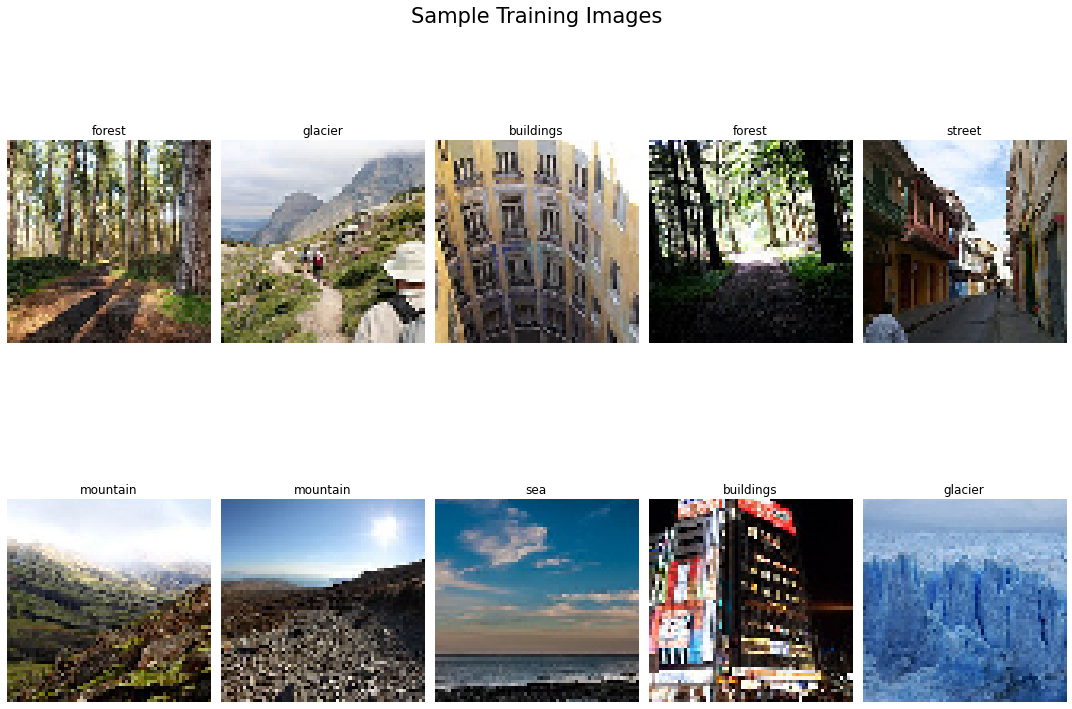

In [ ]:
#2.3 Plotting training images:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_data[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_data[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize = 21)
plt.show()

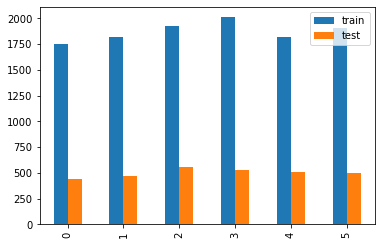

In [ ]:
#2.4 Plotting the number of image per class - training and test set:
_, train_cnt = np.unique(train_data.classes, return_counts = True)
_, test_cnt = np.unique(test_data.classes, return_counts = True)
_, val_cnt = np.unique(val_data.classes, return_counts = True)
pd.DataFrame({'train': train_cnt,
                    'test': test_cnt,
              'val': val_cnt}, 
             index = class_names
            ).plot.bar()
plt.show()

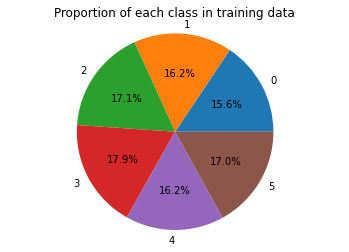

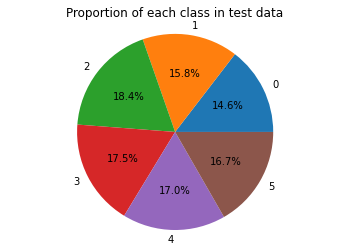

In [ ]:
#2.5 Plotting the proportion of observed categories:
plt.pie(train_cnt,
        explode = (0, 0, 0, 0, 0, 0) , 
        labels = class_names,
        autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each class in training data')
plt.show()


plt.pie(test_cnt,
        explode = (0, 0, 0, 0, 0, 0) , 
        labels = class_names,
        autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each class in test data')
plt.show()

In [ ]:
label_name = []
for key, value in labels.items():
  label_name.append(value)
print(label_name)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


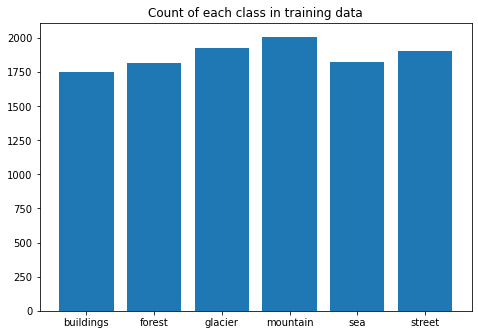

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1,])
ax.bar(x = label_name,
        height = train_cnt)
plt.title('Count of each class in training data')
plt.show()

# Baseline Model

## BUILDING THE BASELINE CNN MODEL

In [3]:
#3. BUILDING THE BASELINE CNN MODEL

#3.1 Create a sequential model:
baseline = Sequential()

#3.2 Adding the convolutional and pooling layers:
baseline.add(layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (64, 64, 3), padding = 'same'))
baseline.add(layers.MaxPooling2D((2, 2)))
baseline.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
baseline.add(layers.MaxPooling2D((2, 2)))
baseline.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
baseline.add(layers.MaxPooling2D((2, 2)))

#3.3 Flatten the baseline model, because dense layers expect vectors:
baseline.add(layers.Flatten())

#3.4 Adding two dense layers of sizes 64 and 32:
baseline.add(layers.Dense(64, activation = 'relu'))
baseline.add(layers.Dense(32, activation = 'relu'))

#3.5 Adding the output layer:
baseline.add(layers.Dense(6, activation = 'softmax'))

baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

## COMPILING, TRAINING & ASSESSING THE BASELINE CNN MODEL

In [4]:
#4. COMPILING, TRAINING & ASSESSING THE BASELINE CNN MODEL

#4.1 Compiling & training the baseline CNN model - Note: learning rate in the Adam optimizir = 0.001:
baseline.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = baseline.fit(train_data, epochs = 20, batch_size = 32,
                       validation_data = val_data)

Epoch 1/20
176/176 [==============================] - 48s 269ms/step - loss: 1.1220 - accuracy: 0.5545 - val_loss: 0.9209 - val_accuracy: 0.6373
Epoch 2/20
176/176 [==============================] - 44s 248ms/step - loss: 0.8345 - accuracy: 0.6801 - val_loss: 0.7461 - val_accuracy: 0.7254
Epoch 3/20
176/176 [==============================] - 43s 245ms/step - loss: 0.6994 - accuracy: 0.7428 - val_loss: 0.6704 - val_accuracy: 0.7607
Epoch 4/20
176/176 [==============================] - 43s 247ms/step - loss: 0.5994 - accuracy: 0.7777 - val_loss: 0.6361 - val_accuracy: 0.7710
Epoch 5/20
176/176 [==============================] - 43s 243ms/step - loss: 0.5085 - accuracy: 0.8167 - val_loss: 0.6581 - val_accuracy: 0.7675
Epoch 6/20
176/176 [==============================] - 43s 242ms/step - loss: 0.4600 - accuracy: 0.8366 - val_loss: 0.5576 - val_accuracy: 0.8031
Epoch 7/20
176/176 [==============================] - 43s 242ms/step - loss: 0.4052 - accuracy: 0.8522 - val_loss: 0.5781 - val_ac

In [5]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.121973,0.554497,0.920879,0.637304
1,0.834478,0.680053,0.746103,0.725392
2,0.699413,0.742832,0.670425,0.760699
3,0.599414,0.777738,0.636145,0.771041
4,0.508507,0.816652,0.658089,0.767475


Text(0.5, 1.0, 'Model accuracy')

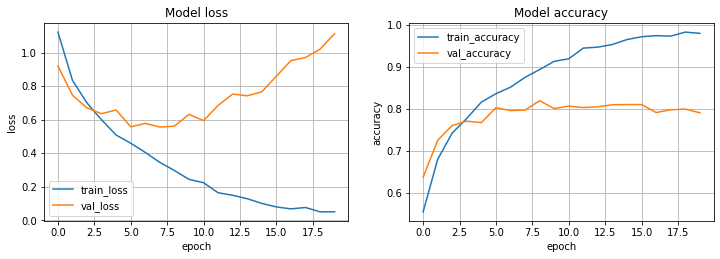

In [6]:
#4.2 Plotting the training and validation performance:
plt.figure(figsize = (12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.title('Model loss')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.title('Model accuracy')

In [8]:
val_loss, val_acc = baseline.evaluate(val_data)

44/44 [==============================] - 2s 48ms/step - loss: 1.1127 - accuracy: 0.7910


In [7]:
test_loss, test_accuracy = baseline.evaluate(test_data)

47/47 [==============================] - 4s 87ms/step - loss: 1.2112 - accuracy: 0.7793


In [9]:
print(f"Val accuracy: {val_acc}, Test accuracy: {test_accuracy}")

Val accuracy: 0.7910128235816956, Test accuracy: 0.7793333530426025


In [10]:
val_pred = baseline.predict(val_data)
val_label_pred = np.argmax(val_pred, axis = 1) 
test_pred = baseline.predict(test_data)
label_pred = np.argmax(test_pred, axis = 1) 
print(label_pred)

47/47 [==============================] - 2s 49ms/step
[0 5 5 ... 3 0 5]


### MODEL EVALUATION
#### Confusion matrix on validation set

           buildings  forest  glacier  mountain  sea  street
buildings        340      10        5        17    4      62
forest            15     411        4         6    1      17
glacier           16       4      335        99   19       7
mountain          17       2       46       416   11      10
sea               27       5       33        66  305      18
street            51       5        3         5    1     411


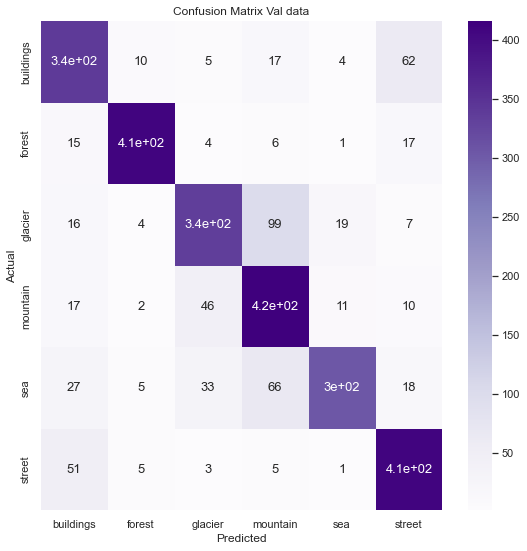

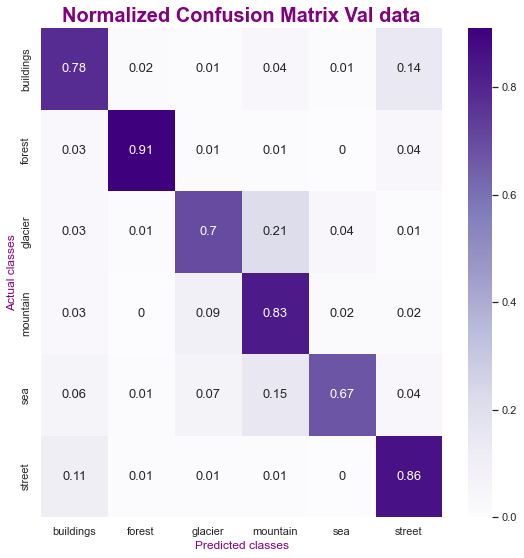

In [20]:
# 4.3 Confusion matrix calculation and plot
# 4.3.1 Confusion matrix on validation set
true_classes = val_data.classes
conf_mat_val = confusion_matrix(y_true = true_classes, y_pred = val_label_pred)
conf_mat_val = pd.DataFrame(conf_mat_val, index = test_data.class_indices.keys(), columns = test_data.class_indices.keys())
print(conf_mat_val)
cm = confusion_matrix(true_classes, val_label_pred)
ax = plt.axes()
sns.heatmap(cm, cmap = "Purples", annot = True, 
           annot_kws = {"size": 13}, 
           xticklabels = val_data.class_indices,
           yticklabels = val_data.class_indices, ax = ax)
ax.set_title('Confusion Matrix Val data')
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.set(rc = {'figure.figsize':(9, 9)})
plt.show()
# plt.savefig("CM_heatmap.pdf", format = "pdf")

cm_normalized = np.round(cm/np.sum(cm, axis = 1).reshape(-1, 1), 2)

cm = confusion_matrix(true_classes, val_label_pred)
ax = plt.axes()
sns.heatmap(cm_normalized, cmap = "Purples", annot = True, 
           annot_kws = {"size": 13}, 
           xticklabels = val_data.class_indices,
           yticklabels = val_data.class_indices, ax = ax)
plt.xlabel("Predicted classes", color = "Purple")
plt.ylabel("Actual classes", color = "Purple")
plt.title("Normalized Confusion Matrix Val data", fontsize = 20, color = "Purple", fontweight = 'bold')
plt.show()
# plt.savefig("norm_CM_heatmap.pdf", format = "pdf")

#### Confusion matrix on test set

In [16]:
# 4.3.2 confusion matrix on test set
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())
conf_mat = confusion_matrix(y_true = true_classes, y_pred = label_pred)
conf_mat = pd.DataFrame(conf_mat, index = test_data.class_indices.keys(), columns = test_data.class_indices.keys())
conf_mat

,buildings,forest,glacier,mountain,sea,street
buildings,338,10,5,13,3,68
forest,15,435,1,2,1,20
glacier,22,3,376,117,20,15
mountain,24,2,57,416,14,12
sea,31,4,48,66,341,20
street,50,9,4,5,1,432


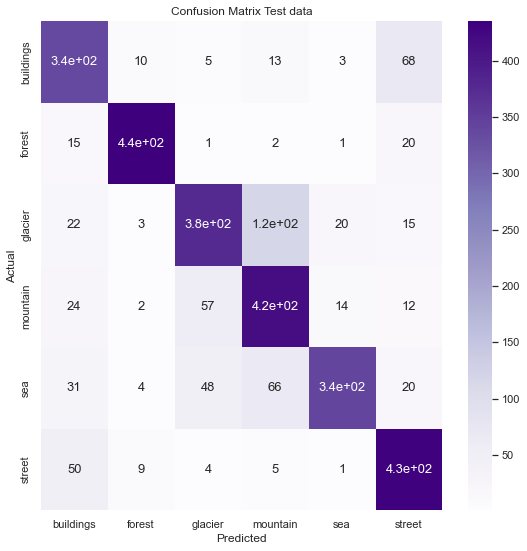

<Figure size 648x648 with 0 Axes>

In [17]:
cm = confusion_matrix(true_classes, label_pred)
ax = plt.axes()
sns.heatmap(cm, cmap = "Purples", annot = True, 
           annot_kws = {"size": 13}, 
           xticklabels = test_data.class_indices,
           yticklabels = test_data.class_indices, ax = ax)
ax.set_title('Confusion Matrix Test data')
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.set(rc = {'figure.figsize':(9, 9)})
plt.show()
# plt.savefig("CM_heatmap", format = "pdf")

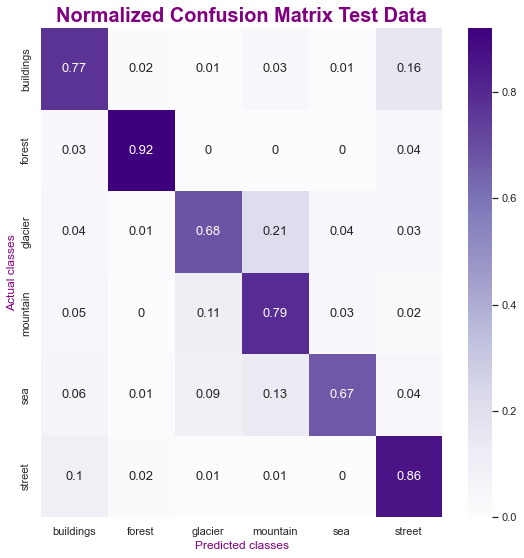

In [19]:
cm_normalized = np.round(cm/np.sum(cm, axis = 1).reshape(-1, 1), 2)

cm = confusion_matrix(true_classes, label_pred)
ax = plt.axes()
sns.heatmap(cm_normalized, cmap = "Purples", annot = True, 
           annot_kws = {"size": 13}, 
           xticklabels = test_data.class_indices,
           yticklabels = test_data.class_indices, ax = ax)
plt.xlabel("Predicted classes", color = "Purple")
plt.ylabel("Actual classes", color = "Purple")
plt.title("Normalized Confusion Matrix Test Data", fontsize = 20, color = "Purple", fontweight = 'bold')
plt.show()
# plt.savefig("norm_CM_heatmap", format = "pdf")

### Metrics

#### Metrics on validation set

In [21]:
# 4.4 Precision, recall & f1-score:
# 4.4.0 Measure on the validation set

true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

report = classification_report(true_classes, val_label_pred, target_names = class_labels)
print(report)

#4.5 Accuracy:
accuracy = accuracy_score(y_true = true_classes, y_pred = val_label_pred)
print("Accuracy score = ", accuracy)

#4.6 Sensitivity - simply averaging all the sensitivities by class:
sensitivity = recall_score(y_true = true_classes, y_pred = val_label_pred, average = "macro")
print("Sensitivity score = ", sensitivity)

#4.7 F1-score:
f1score = f1_score(y_true = true_classes, y_pred = val_label_pred, average = 'weighted')
print("F1-score = ", f1score)

#4.7 Specificity:
def specificity(y_true: np.array, y_pred: np.array, classes: set = None):

    if classes is None: # Determine classes from the values
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))

    specs = []
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)

        specificity_val = tn / (tn + fp)
        specs.append(specificity_val)

    return np.mean(specs)
specificity = specificity(y_true = true_classes, y_pred = val_label_pred)
print("Specificity score = ", specificity)

res = []
for l in [0, 1, 2, 3, 4, 5]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(true_classes) == l,
                                                      np.array(val_label_pred) == l,
                                                      pos_label = True,average = None)
    res.append([l,recall[0],recall[1]])

print(pd.DataFrame(res,columns = ['class', 'specificity', 'sensitivity']))

              precision    recall  f1-score   support

   buildings       0.73      0.78      0.75       438
      forest       0.94      0.91      0.92       454
     glacier       0.79      0.70      0.74       480
    mountain       0.68      0.83      0.75       502
         sea       0.89      0.67      0.77       454
      street       0.78      0.86      0.82       476

    accuracy                           0.79      2804
   macro avg       0.80      0.79      0.79      2804
weighted avg       0.80      0.79      0.79      2804

Accuracy score =  0.7910128388017118
Sensitivity score =  0.7905659204263072
F1-score =  0.7911719609365101
Specificity score =  0.9580661242877073
   class  specificity  sensitivity
0      0     0.946746     0.776256
1      1     0.988936     0.905286
2      2     0.960843     0.697917
3      3     0.916160     0.828685
4      4     0.984681     0.671806
5      5     0.951031     0.863445


#### Metrics on test set

In [22]:
# Below are on test set
# 4.4 Precision, recall & f1-score:
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

report = classification_report(true_classes, label_pred, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

   buildings       0.70      0.77      0.74       437
      forest       0.94      0.92      0.93       474
     glacier       0.77      0.68      0.72       553
    mountain       0.67      0.79      0.73       525
         sea       0.90      0.67      0.77       510
      street       0.76      0.86      0.81       501

    accuracy                           0.78      3000
   macro avg       0.79      0.78      0.78      3000
weighted avg       0.79      0.78      0.78      3000



In [23]:
#4.5 Accuracy:
accuracy = accuracy_score(y_true = true_classes, y_pred = label_pred)
print("Accuracy score = ", accuracy)

#4.6 Sensitivity - simply averaging all the sensitivities by class:
sensitivity = recall_score(y_true = true_classes, y_pred = label_pred, average = "macro")
print("Sensitivity score = ", sensitivity)

#4.7 F1-score:
f1score = f1_score(y_true = true_classes, y_pred = label_pred, average = 'weighted')
print("F1-score = ", f1score)

Accuracy score =  0.7793333333333333
Sensitivity score =  0.7823980693823821
F1-score =  0.7795057525336694


In [24]:
#4.8 Specificity & sensitivity per class:
def specificity(y_true: np.array, y_pred: np.array, classes: set = None):

    if classes is None: # Determine classes from the values
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))

    specs = []
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)

        specificity_val = tn / (tn + fp)
        specs.append(specificity_val)

    return np.mean(specs)
specificity = specificity(y_true = true_classes, y_pred = label_pred)
print("Specificity score = ", specificity)

Specificity score =  0.9558017790232656


In [25]:
res = []
for l in [0, 1, 2, 3, 4, 5]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(true_classes) == l,
                                                      np.array(label_pred) == l,
                                                      pos_label = True,average = None)
    res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class', 'specificity', 'sensitivity'])

,class,specificity,sensitivity
0,0,0.944596,0.773455
1,1,0.988915,0.917722
2,2,0.953004,0.679928
3,3,0.917980,0.792381
4,4,0.984337,0.668627
5,5,0.945978,0.862275


### AUC-ROC CURVES

#### On validation set

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


C:\Users\yye\AppData\Local\Temp\ipykernel_28620\2944584040.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


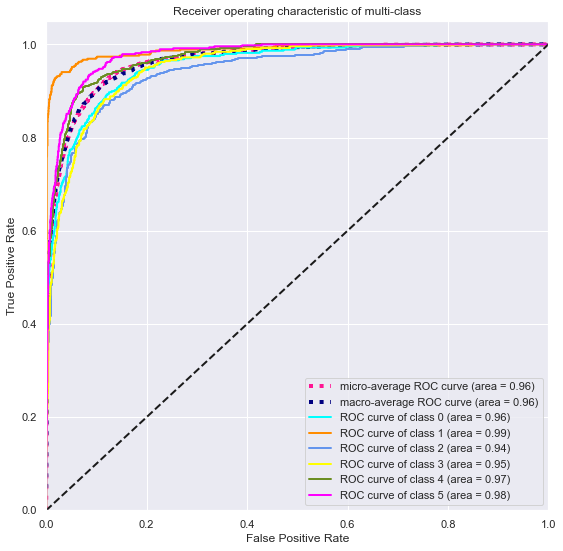

In [28]:
# 5. THE ROC CURVES
# 5.1 on validation set 
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

y_test_onehot = pd.get_dummies(val_label_pred)

#5.1.1 Plotting linewidth:
lw = 2

oh_enc = OneHotEncoder(sparse = False)
true = true_classes.reshape(len(true_classes), 1)
ohe_true_classes = oh_enc.fit_transform(true)
print(ohe_true_classes)

#5.1.2 Computing ROC & ROC for each class:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ohe_true_classes[:, i], val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#5.1.3 Computing micro-average ROC & AUC:
fpr["micro"], tpr["micro"], _ = roc_curve(ohe_true_classes.ravel(), val_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#51..4 Computing macro-average ROC & AUC:
#5.4.1 Aggregate all false positive rates:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#5.1.4.2 Interpolate all ROC curves at these points:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#5.1.4.3 Finally, average it and compute AUC:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#5.1.5 Plotting all ROC curves:
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label = 'micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color = 'deeppink', linestyle = ':', linewidth = 4)

plt.plot(fpr["macro"], tpr["macro"],
         label = 'macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color = 'navy', linestyle =':', linewidth = 4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow', 'olivedrab', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = lw,
             label = 'ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw = lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of multi-class')
plt.legend(loc = "lower right")
plt.show()

#### On test set

In [29]:
# 5.2 On testing set
# 5.2.0. Preparing for ROC curve:
y_test_onehot = pd.get_dummies(label_pred)
y_test_onehot.tail()

,0,1,2,3,4,5
2995,0,0,0,0,0,1
2996,0,0,0,0,0,1
2997,0,0,0,1,0,0
2998,1,0,0,0,0,0
2999,0,0,0,0,0,1


[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


C:\Users\yye\AppData\Local\Temp\ipykernel_28620\1927773975.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


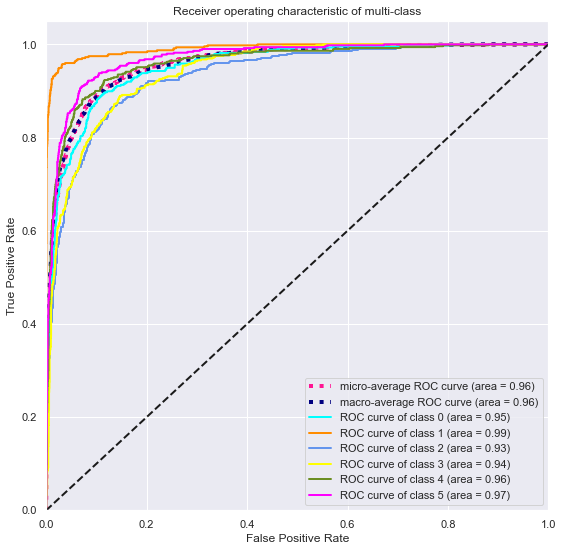

In [31]:

#5.1 Plotting linewidth:
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

lw = 2

oh_enc = OneHotEncoder(sparse = False)
true = true_classes.reshape(len(true_classes), 1)
ohe_true_classes = oh_enc.fit_transform(true)
print(ohe_true_classes)

#5.2 Computing ROC & ROC for each class:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ohe_true_classes[:, i], test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#5.3 Computing micro-average ROC & AUC:
fpr["micro"], tpr["micro"], _ = roc_curve(ohe_true_classes.ravel(), test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#5.4 Computing macro-average ROC & AUC:
#5.4.1 Aggregate all false positive rates:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#5.4.2 Interpolate all ROC curves at these points:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#5.4.3 Finally, average it and compute AUC:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#5.5 Plotting all ROC curves:
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label = 'micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color = 'deeppink', linestyle = ':', linewidth = 4)

plt.plot(fpr["macro"], tpr["macro"],
         label = 'macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color = 'navy', linestyle =':', linewidth = 4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow', 'olivedrab', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = lw,
             label = 'ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw = lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of multi-class')
plt.legend(loc = "lower right")
plt.show()

# Tuned Model

## TUNING THE BASELINE CNN MODEL

In [ ]:
#6. TUNING THE BASELINE CNN MODEL

#6.1 Create a sequential model:
tuned_model = Sequential()

#6.2 Adding strides to the convolutional and pooling layers:
tuned_model.add(layers.Conv2D(64,
                           kernel_size = (3, 3),
                           activation = 'relu',
                           input_shape = (64, 64, 3),
                           padding = 'same',
                           strides = 1))
tuned_model.add(layers.MaxPooling2D(pool_size = (2, 2),
                                    padding = 'same',
                                    strides = 2))

tuned_model.add(layers.Conv2D(64,
                           kernel_size = (3, 3),
                           activation = 'relu',
                           padding = 'same',
                           strides = 1))
tuned_model.add(layers.MaxPooling2D(pool_size = (2, 2),
                                    padding = 'same',
                                    strides = 2))

tuned_model.add(layers.Conv2D(64,
                           kernel_size = (3, 3),
                           activation = 'relu',
                           padding = 'same',
                           strides = 1))
tuned_model.add(layers.MaxPooling2D(pool_size = (2, 2),
                                    padding = 'same',
                                    strides = 2))

#6.3 Flatten the tuned model, because dense layers expect vectors:
tuned_model.add(layers.Flatten())

#6.4 Two dense layers of sizes 64 and 32, dropout layer with a rate of 0.25 & L2 regularizer:
tuned_model.add(layers.Dense(64,
                             activation = 'relu',
                             kernel_regularizer = regularizers.L2(0.001)))

tuned_model.add(layers.Dense(32,
                             activation = 'relu',
                             kernel_regularizer = regularizers.L2(0.001)))
tuned_model.add(layers.Dropout(rate = 0.25))

#6.5 Adding the output layer:
tuned_model.add(layers.Dense(6, activation = 'softmax'))

tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               


2022-10-05 08:33:04.167138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (

## COMPILING, TRAINING & ASSESSING THE TUNED CNN MODEL

In [ ]:
#7. COMPILING, TRAINING & ASSESSING THE TUNED CNN MODEL

#7.1 Adding early stopping:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         patience = 5,
                                         restore_best_weights = True)

#7.2 Compiling & training the baseline CNN model - learning rate = 0.0005:
tuned_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0005), loss = 'categorical_crossentropy', metrics = ['accuracy'])
tuned_history = tuned_model.fit(train_data,
                             epochs = 40,
                             batch_size = 32,
                             validation_data = val_data,
                             callbacks = [early_stopping])

Epoch 1/40
176/176 [==============================] - 125s 702ms/step - loss: 1.3459 - accuracy: 0.5081 - val_loss: 1.0348 - val_accuracy: 0.6377
Epoch 2/40
176/176 [==============================] - 114s 648ms/step - loss: 1.0050 - accuracy: 0.6425 - val_loss: 0.8888 - val_accuracy: 0.6840
Epoch 3/40
176/176 [==============================] - 117s 664ms/step - loss: 0.9064 - accuracy: 0.6935 - val_loss: 0.8336 - val_accuracy: 0.7019
Epoch 4/40
176/176 [==============================] - 136s 771ms/step - loss: 0.8174 - accuracy: 0.7330 - val_loss: 0.9052 - val_accuracy: 0.6929
Epoch 5/40
176/176 [==============================] - 119s 678ms/step - loss: 0.7474 - accuracy: 0.7561 - val_loss: 0.7029 - val_accuracy: 0.7675
Epoch 6/40
176/176 [==============================] - 119s 678ms/step - loss: 0.6920 - accuracy: 0.7738 - val_loss: 0.6601 - val_accuracy: 0.7924
Epoch 7/40
176/176 [==============================] - 120s 681ms/step - loss: 0.6492 - accuracy: 0.7929 - val_loss: 0.6348 -

In [ ]:
tuned_history_df = pd.DataFrame(tuned_history.history)
tuned_history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.345938,0.508103,1.034752,0.637661
1,1.005019,0.642475,0.888759,0.684023
2,0.906446,0.693500,0.833570,0.701854
3,0.817410,0.733037,0.905173,0.692939
4,0.747443,0.756100,0.702881,0.767475


Text(0.5, 1.0, 'Model accuracy')

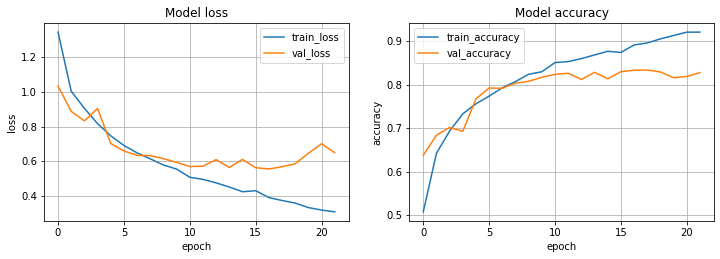

In [ ]:
#7.2 Plotting the training and validation performance:
plt.figure(figsize = (12, 8))

plt.subplot(2, 2, 1)
plt.plot(tuned_history.history['loss'], label = 'train_loss')
plt.plot(tuned_history.history['val_loss'], label = 'val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.title('Model loss')

plt.subplot(2, 2, 2)
plt.plot(tuned_history.history['accuracy'], label = 'train_accuracy')
plt.plot(tuned_history.history['val_accuracy'], label = 'val_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.title('Model accuracy')

In [ ]:
tuned_test_loss, tuned_test_accuracy = tuned_model.evaluate(test_data)

47/47 [==============================] - 9s 193ms/step - loss: 0.5729 - accuracy: 0.8277


In [ ]:
print(f"Test accuracy: {tuned_test_accuracy}") 

Test accuracy: 0.8276666402816772


In [ ]:
tuned_test_pred = tuned_model.predict(test_data)
tuned_label_pred = np.argmax(tuned_test_pred, axis = 1) 
print(tuned_label_pred)

47/47 [==============================] - 10s 204ms/step
[0 5 0 ... 3 0 5]


In [ ]:
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

In [ ]:
np.save("/Users/umutaldemir/MSC DSS/DL/PROJECT/tuned_label_pred.npy", tuned_label_pred)

## CONFUSION MATRIX

In [ ]:
# 7.3 Confusion Matrix
tuned_conf_mat = confusion_matrix(y_true = true_classes, y_pred = tuned_label_pred)
tuned_conf_mat = pd.DataFrame(tuned_conf_mat, index = test_data.class_indices.keys(), columns = test_data.class_indices.keys())

In [ ]:
tuned_conf_mat

,buildings,forest,glacier,mountain,sea,street
buildings,346,8,2,8,15,58
forest,3,445,2,4,2,18
glacier,5,4,415,85,36,8
mountain,7,1,56,414,41,6
sea,16,5,29,27,425,8
street,45,7,2,3,6,438


In [ ]:
tuned_conf_mat.to_csv("/Users/umutaldemir/MSC DSS/DL/PROJECT/tuned_confusion_matrix.csv")

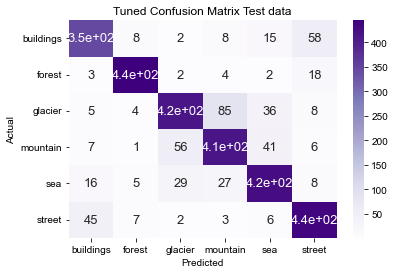

<Figure size 648x648 with 0 Axes>

In [ ]:
tuned_cm = confusion_matrix(true_classes, tuned_label_pred)
ax = plt.axes()
sns.heatmap(tuned_cm, cmap = "Purples", annot = True, 
           annot_kws = {"size": 13}, 
           xticklabels = test_data.class_indices,
           yticklabels = test_data.class_indices, ax = ax)
ax.set_title('Tuned Confusion Matrix Test data')
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.set(rc = {'figure.figsize':(9, 9)})
plt.show()
plt.savefig("tuned_CM_heatmap", format = "pdf")

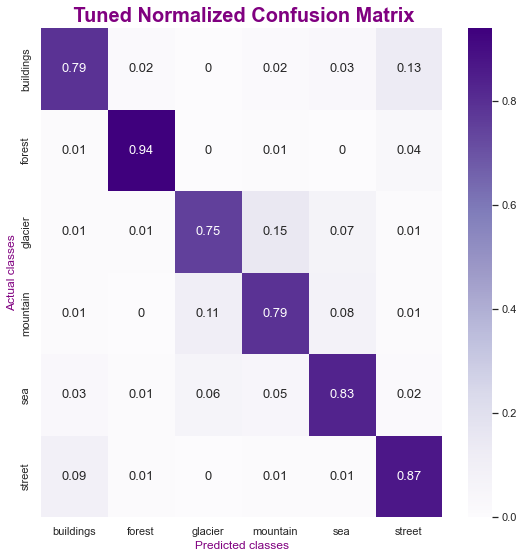

<Figure size 648x648 with 0 Axes>

In [ ]:
tuned_cm_normalized = np.round(tuned_cm/np.sum(tuned_cm, axis = 1).reshape(-1, 1), 2)

cm = confusion_matrix(true_classes, tuned_label_pred)
ax = plt.axes()
sns.heatmap(tuned_cm_normalized, cmap = "Purples", annot = True, 
           annot_kws = {"size": 13}, 
           xticklabels = test_data.class_indices,
           yticklabels = test_data.class_indices, ax = ax)
plt.xlabel("Predicted classes", color = "Purple")
plt.ylabel("Actual classes", color = "Purple")
plt.title(" Tuned Normalized Confusion Matrix", fontsize = 20, color = "Purple", fontweight = 'bold')
plt.show()
plt.savefig("tuned_norm_CM_heatmap", format = "pdf")

In [ ]:
#7.4 Precision, recall & f1-score:
tuned_report = classification_report(true_classes, tuned_label_pred, target_names = class_labels)
print(tuned_report)

              precision    recall  f1-score   support

   buildings       0.82      0.79      0.81       437
      forest       0.95      0.94      0.94       474
     glacier       0.82      0.75      0.78       553
    mountain       0.77      0.79      0.78       525
         sea       0.81      0.83      0.82       510
      street       0.82      0.87      0.84       501

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



In [ ]:
#7.5 Accuracy:
accuracy = accuracy_score(y_true = true_classes, y_pred = tuned_label_pred)
print("Accuracy score = ", accuracy)

#7.6 Sensitivity - simply averaging all the sensitivities by class:
sensitivity = recall_score(y_true = true_classes, y_pred = tuned_label_pred, average = "macro")
print("Sensitivity score = ", sensitivity)

#7.7 F1-score:
f1score = f1_score(y_true = true_classes, y_pred = tuned_label_pred, average = 'weighted')
print("F1-score = ", f1score)


Accuracy score =  0.8276666666666667
Sensitivity score =  0.8295314862679289
F1-score =  0.8273964965512229


In [ ]:
#7.8 Specificity:
def specificity(y_true: np.array, y_pred: np.array, classes: set = None):

    if classes is None: # Determine classes from the values
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))

    specs = []
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)

        specificity_val = tn / (tn + fp)
        specs.append(specificity_val)

    return np.mean(specs)
specificity = specificity(y_true = true_classes, y_pred = tuned_label_pred)
print("Specificity score = ", specificity)

Specificity score =  0.9654287207900607


In [ ]:
#7.9 Specificity & sensitivity per class:
res = []
for l in [0, 1, 2, 3, 4, 5]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(true_classes) == l,
                                                      np.array(tuned_label_pred) == l,
                                                      pos_label = True,average = None)
    res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

,class,specificity,sensitivity
0,0,0.970347,0.791762
1,1,0.990103,0.938819
2,2,0.962812,0.750452
3,3,0.948687,0.788571
4,4,0.959839,0.833333
5,5,0.960784,0.874251


In [ ]:
#8. THE ROC CURVES

#8.0 Preparing for ROC curve:
y_test_onehot = pd.get_dummies(tuned_label_pred)
y_test_onehot.tail()

,0,1,2,3,4,5
2995,0,0,0,0,0,1
2996,0,0,0,0,0,1
2997,0,0,0,1,0,0
2998,1,0,0,0,0,0
2999,0,0,0,0,0,1


[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


/var/folders/98/kttfxt7d7f1fv3shp9t9wr3c0000gn/T/ipykernel_10050/385723269.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


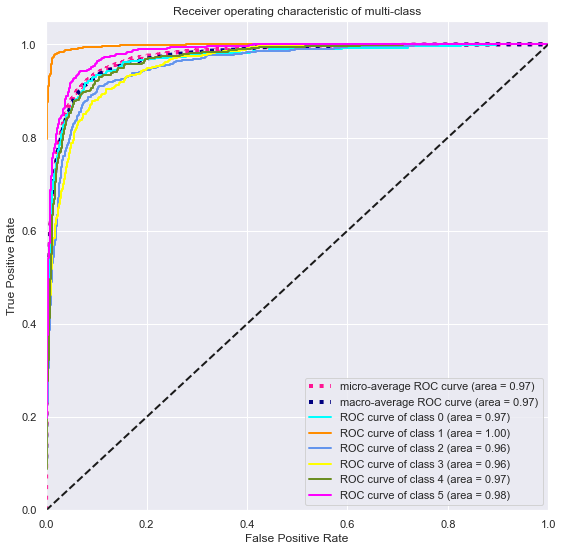

In [ ]:
#8.1 Plotting linewidth:
lw = 2

oh_enc = OneHotEncoder(sparse = False)
true = true_classes.reshape(len(true_classes), 1)
ohe_true_classes = oh_enc.fit_transform(true)
print(ohe_true_classes)

#8.2 Computing ROC & ROC for each class:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ohe_true_classes[:, i], tuned_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#8.3 Computing micro-average ROC & AUC:
fpr["micro"], tpr["micro"], _ = roc_curve(ohe_true_classes.ravel(), tuned_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#8.4 Computing macro-average ROC & AUC:
#8.4.1 Aggregate all false positive rates:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#8.4.2 Interpolate all ROC curves at these points:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#8.4.3 Finally, average it and compute AUC:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#8.5 Plotting all ROC curves:
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label = 'micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color = 'deeppink', linestyle = ':', linewidth = 4)

plt.plot(fpr["macro"], tpr["macro"],
         label = 'macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color = 'navy', linestyle =':', linewidth = 4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow', 'olivedrab', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = lw,
             label = 'ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw = lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of multi-class')
plt.legend(loc = "lower right")
plt.show()

# Tuning Model with Random Search

In [32]:
# 9. TUNING THE BASELINE MODEL with
# 9.1 Define a function that has the similiar architecture with baseline model
# but it contains different options of hyperparamers in each layer
def create_model(hyperparams):
    # 9.1.1 Create a sequential model
    model = Sequential()

    # 9.1.2 Adding the convolutional and pooling layers:
    # add one more convolutional layer before the last maxipooling layer
    model.add(layers.Conv2D(filters = hyperparams.Int("filter_size1", 64, 128, step=64), 
                            kernel_size = hyperparams.Choice('kernel_size1',values=[3,7]), 
                            activation= "relu",
                            input_shape = (64, 64, 3), padding = 'same',
                            strides = hyperparams.Int("stride1", 1, 2, step=1),
                            kernel_regularizer = regularizers.L2(hyperparams.Choice('l2 reg1', [0.0, 1e-2]))
                            ))                            
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters = hyperparams.Int("filter_size2", 64, 256, step=64), 
                            kernel_size = hyperparams.Choice('kernel_size2',values=[3,7]), 
                            activation= "relu",
                            padding = 'same',
                            strides = hyperparams.Int("stride2", 1, 2, step=1),
                            kernel_regularizer = regularizers.L2(hyperparams.Choice('l2 reg2', [0.0, 1e-2]))
                            ))                                                     
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters = hyperparams.Int("filter_size3", 64, 512, step=64), 
                            kernel_size = hyperparams.Choice('kernel_size3',values=[3,7]), 
                            activation= "relu",
                            padding = 'same',
                            strides = hyperparams.Int("stride3", 1, 2, step=1),
                            kernel_regularizer = regularizers.L2(hyperparams.Choice('l2 reg3', [0.0, 1e-2]))
                            ))
    model.add(layers.Conv2D(filters = hyperparams.Int("filter_size3x", 64, 512, step=64), 
                            kernel_size = hyperparams.Choice('kernel_size3x',values=[3,7]), 
                            activation= "relu",
                            input_shape = (64, 64, 3), padding = 'same',
                            strides = hyperparams.Int("stride3x", 1, 2, step=1),
                            kernel_regularizer = regularizers.L2(hyperparams.Choice('l2 reg3x', [0.0, 1e-2]))
                            ))                                                        
    model.add(layers.MaxPooling2D((2, 2)))

    # 9.1.3 Flatten the model, because dense layers expect vectors:
    model.add(layers.Flatten())

    # 9.1.4 Adding two dense layers, one has min = 0, so we can see if the layer is necessary:  
    model.add(layers.Dense(units=hyperparams.Int("units_l4", 64, 256, step=32),
                           use_bias=hyperparams.Boolean("bias_l1"),
                           activation= "relu",
                           kernel_regularizer = regularizers.L2(hyperparams.Choice('l2 reg4', [0.0, 1e-2]))
                          ))
    model.add(layers.Dropout(rate = hyperparams.Float("drop_rate_1", 0, 0.5, step=0.05)))                          
    model.add(layers.Dense(units=hyperparams.Int("units_l5", 0, 64, step=32),
                           use_bias=hyperparams.Boolean("bias_l2"),
                           activation= "relu",
                           kernel_regularizer = regularizers.L2(hyperparams.Choice('l2 reg5', [0.0, 1e-2]))
                          ))                         
    # 9.1.5 Adding the output layer:
    model.add(layers.Dense(6, activation = 'softmax'))

    # 9.1.6 Try Adam with different learning rate
    hp_lr = hyperparams.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer= optimizers.Adam(learning_rate=hp_lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model


In [ ]:
# 9.2 Use Keras tuner to do random search
# 9.2.1 Set different values for the random search, the tuner will save the hyperparameters with best val_accuracy 

tuner1 =  RandomSearch(hypermodel=create_model,
                      # objective="categorical_crossentropy",
                      objective=Objective(name="val_accuracy",direction="max"),
                      max_trials=5,
                      seed=10,
                      overwrite=True)
tuner1.search(train_data, batch_size=64, epochs=10, validation_data=val_data)

Trial 5 Complete [00h 54m 02s]
val_accuracy: 0.8181169629096985

Best val_accuracy So Far: 0.8181169629096985
Total elapsed time: 04h 53m 26s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# 9.2.2 Extract the best hp
best_hps = tuner1.get_best_hyperparameters()[0]
best_hps.get_config()['values']

{'filter_size1': 128,
 'kernel_size1': 3,
 'stride1': 1,
 'l2 reg1': 0.01,
 'filter_size2': 256,
 'kernel_size2': 3,
 'stride2': 1,
 'l2 reg2': 0.0,
 'filter_size3': 192,
 'kernel_size3': 7,
 'stride3': 2,
 'l2 reg3': 0.0,
 'filter_size3x': 384,
 'kernel_size3x': 7,
 'stride3x': 2,
 'l2 reg3x': 0.0,
 'units_l4': 160,
 'bias_l1': True,
 'l2 reg4': 0.01,
 'drop_rate_1': 0.45,
 'units_l5': 32,
 'bias_l2': True,
 'l2 reg5': 0.0,
 'learning_rate': 0.0001}

In [ ]:
# 9.2.3 Check the architecture of the final best model from random search
tuner1.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 192)         2408640   
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 384)         3

In [ ]:
# 10 TRAINING & ASSESSING THE BEST MODEL FROM RANDOM SEARCH
# 10.1 Create the tuned model with the hyperparameters from the tuner for the trainiing
tuned_model2 = tuner1.hypermodel.build(best_hps)

In [ ]:
# 10.2 Create the callbacks we want to use
#### NOTE!!! We save the best model weights during training to control the overfitting
def create_callbacks():
  early_stopping = EarlyStopping(patience=5, monitor='val_loss', verbose=1)

  #reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=0.001, patience=5, mode='min', verbose=1)

  model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                     filepath='rs_model',
                                     save_weights_only=True,
                                     save_best_only=True,
                                     verbose=1)
  callbacks = [
      early_stopping,
      # reduce_lr,
      model_checkpoint
  ]

  return callbacks

In [ ]:
# 10.3 Training the baseline CNN model - Note: learning rate in the Adam optimizir = 0.0001:
# Define the steps_per_epoch and validation_steps to improve accuracy
STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
STEP_SIZE_VALID = val_data.n//val_data.batch_size
tuned_history2 = tuned_model2.fit(train_data,
                             epochs = 40,
                             batch_size = 64,
                             steps_per_epoch= STEP_SIZE_TRAIN,
                             validation_data = val_data,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks = create_callbacks())

Epoch 1/40
175/175 [==============================] - ETA: 0s - loss: 3.5877 - accuracy: 0.5677
Epoch 1: val_loss improved from inf to 2.95373, saving model to rs_model.h5
175/175 [==============================] - 294s 2s/step - loss: 3.5877 - accuracy: 0.5677 - val_loss: 2.9537 - val_accuracy: 0.6588
Epoch 2/40
175/175 [==============================] - ETA: 0s - loss: 2.6186 - accuracy: 0.6761
Epoch 2: val_loss improved from 2.95373 to 2.31548, saving model to rs_model.h5
175/175 [==============================] - 300s 2s/step - loss: 2.6186 - accuracy: 0.6761 - val_loss: 2.3155 - val_accuracy: 0.6733
Epoch 3/40
175/175 [==============================] - ETA: 0s - loss: 2.0588 - accuracy: 0.7225
Epoch 3: val_loss improved from 2.31548 to 1.79771, saving model to rs_model.h5
175/175 [==============================] - 299s 2s/step - loss: 2.0588 - accuracy: 0.7225 - val_loss: 1.7977 - val_accuracy: 0.7460
Epoch 4/40
175/175 [==============================] - ETA: 0s - loss: 1.6463 - a

In [ ]:
tuned_history2_df = pd.DataFrame(tuned_history2.history)
tuned_history2_df.head()

,loss,accuracy,val_loss,val_accuracy
0,3.587725,0.567706,2.953734,0.658794
1,2.618561,0.676070,2.315481,0.673328
2,2.058829,0.722461,1.797712,0.746003
3,1.646321,0.763299,1.498519,0.774346
4,1.385628,0.778703,1.292010,0.782703


Text(0.5, 1.0, 'Model accuracy')

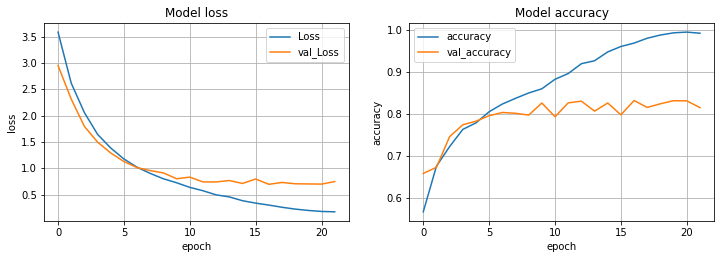

In [ ]:
#10.4 Plotting the training and validation performance:
plt.figure(figsize = (12, 8))

plt.subplot(2, 2, 1)
plt.plot(tuned_history2.history['loss'], label = 'Loss')
plt.plot(tuned_history2.history['val_loss'], label = 'val_Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.title('Model loss')

plt.subplot(2, 2, 2)
plt.plot(tuned_history2.history['accuracy'], label = 'accuracy')
plt.plot(tuned_history2.history['val_accuracy'], label = 'val_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.title('Model accuracy')

In [ ]:
# 10.5 Load the best weights that were saved to evaluate on validation and test set

In [47]:
tuned_model2 = create_model()
tuned_model2.load_weights('./rs_model.ckpt')
tuned2_val_loss, tuned2_val_accuracy = tuned_model2.evaluate(val_data)
tuned2_test_loss, tuned2_test_accuracy = tuned_model2.evaluate(test_data)

47/47 [==============================] - 16s 338ms/step - loss: 0.7053 - accuracy: 0.8327


In [49]:
print(f"Val accuracy: {tuned2_val_accuracy}, val loss: {tuned2_val_loss}\
    Test accuracy: {tuned2_test_accuracy}, test loss: {tuned2_test_loss}") 

Val accuracy: 0.8327389359474182, val loss: 0.6935280561447144    Test accuracy: 0.8326666951179504, test loss: 0.7052626013755798


In [52]:
tuned2_val_pred = tuned_model2.predict(val_data)
tuned2_label_pred_val = np.argmax(tuned2_val_pred, axis = 1) 

tuned2_test_pred = tuned_model2.predict(test_data)
tuned2_label_pred = np.argmax(tuned2_test_pred, axis = 1) 
print(tuned2_label_pred)

47/47 [==============================] - 16s 338ms/step
[0 5 0 ... 3 0 5]


### Confusion Matrix

#### On validation set

           buildings  forest  glacier  mountain  sea  street
buildings        357       4        5        14   15      43
forest             5     422        2        10    3      12
glacier            9       1      366        81   17       6
mountain           7       1       47       427   15       5
sea               21       1       32        53  345       2
street            37       4        3         6    8     418


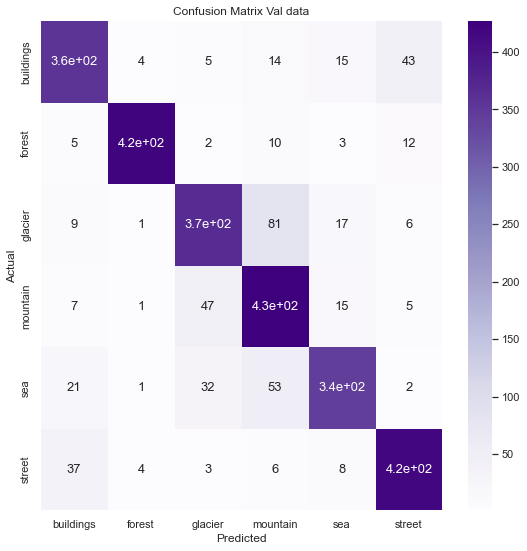

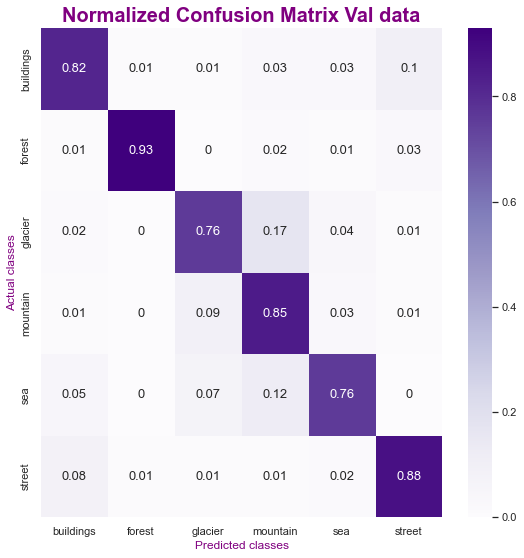

In [54]:
# 4.3 Confusion matrix calculation and plot
# 4.3.1 Confusion matrix on validation set
true_classes = val_data.classes
conf_mat_val = confusion_matrix(y_true = true_classes, y_pred = tuned2_label_pred_val)
conf_mat_val = pd.DataFrame(conf_mat_val, index = test_data.class_indices.keys(), columns = test_data.class_indices.keys())
print(conf_mat_val)
cm = confusion_matrix(true_classes, tuned2_label_pred_val)
ax = plt.axes()
sns.heatmap(cm, cmap = "Purples", annot = True, 
           annot_kws = {"size": 13}, 
           xticklabels = val_data.class_indices,
           yticklabels = val_data.class_indices, ax = ax)
ax.set_title('Confusion Matrix Val data')
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.set(rc = {'figure.figsize':(9, 9)})
plt.show()
# plt.savefig("CM_heatmap.pdf", format = "pdf")

cm_normalized = np.round(cm/np.sum(cm, axis = 1).reshape(-1, 1), 2)

cm = confusion_matrix(true_classes, tuned2_label_pred_val)
ax = plt.axes()
sns.heatmap(cm_normalized, cmap = "Purples", annot = True, 
           annot_kws = {"size": 13}, 
           xticklabels = val_data.class_indices,
           yticklabels = val_data.class_indices, ax = ax)
plt.xlabel("Predicted classes", color = "Purple")
plt.ylabel("Actual classes", color = "Purple")
plt.title("Normalized Confusion Matrix Val data", fontsize = 20, color = "Purple", fontweight = 'bold')
plt.show()
# plt.savefig("norm_CM_heatmap.pdf", format = "pdf")

#### On test set

In [ ]:
# 10.6.2 Confusion matrix on test set
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

from sklearn.metrics import confusion_matrix
tuned_conf_mat2 = confusion_matrix(y_true = true_classes, y_pred = tuned2_label_pred)
tuned_conf_mat2 = pd.DataFrame(tuned_conf_mat2, index = test_data.class_indices.keys(), columns = test_data.class_indices.keys())

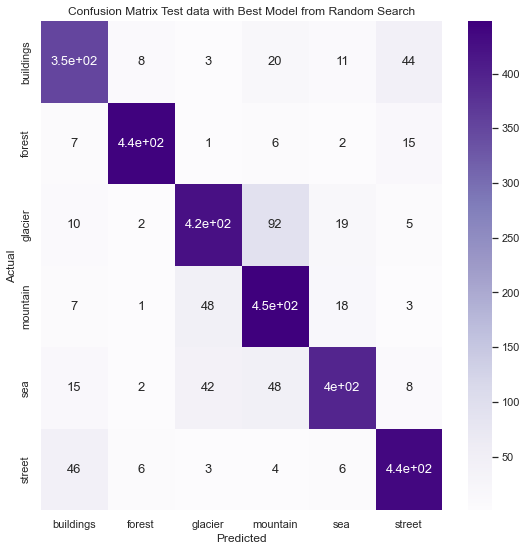

In [ ]:
tuned_cm2 = confusion_matrix(true_classes, tuned2_label_pred)
ax = plt.axes()
sns.heatmap(tuned_cm2, cmap = "Purples", annot = True, 
           annot_kws = {"size": 13}, 
           xticklabels = test_data.class_indices,
           yticklabels = test_data.class_indices, ax = ax)
ax.set_title('Confusion Matrix Test data with Best Model from Random Search')
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.set(rc = {'figure.figsize':(9, 9)})
plt.show()
# plt.savefig("tuned_CM2_heatmap", format = "pdf")

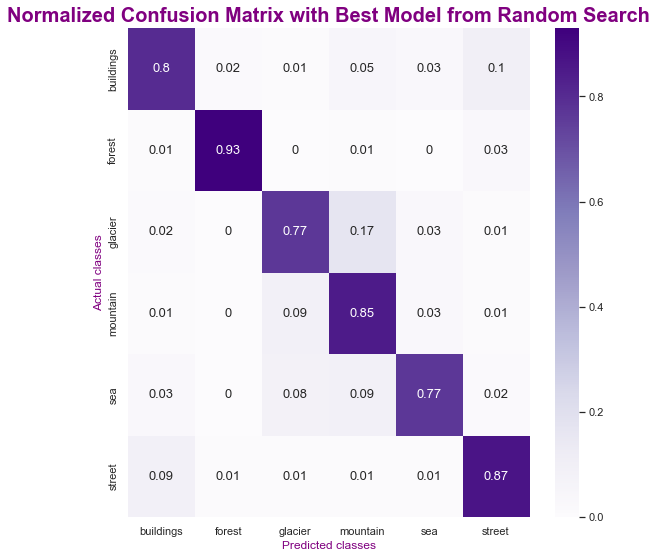

In [ ]:
tuned_cm_normalized2 = np.round(tuned_cm2/np.sum(tuned_cm2, axis = 1).reshape(-1, 1), 2)

cm = confusion_matrix(true_classes, tuned_label_pred)
ax = plt.axes()
sns.heatmap(tuned_cm_normalized2, cmap = "Purples", annot = True, 
           annot_kws = {"size": 13}, 
           xticklabels = test_data.class_indices,
           yticklabels = test_data.class_indices, ax = ax)
plt.xlabel("Predicted classes", color = "Purple")
plt.ylabel("Actual classes", color = "Purple")
plt.title("Normalized Confusion Matrix with Best Model from Random Search", fontsize = 20, color = "Purple", fontweight = 'bold')
plt.show()
# plt.savefig("tuned_norm_CM_heatmap2", format = "pdf")

In [ ]:
tuned_conf_mat2

,buildings,forest,glacier,mountain,sea,street
buildings,351,8,3,20,11,44
forest,7,443,1,6,2,15
glacier,10,2,425,92,19,5
mountain,7,1,48,448,18,3
sea,15,2,42,48,395,8
street,46,6,3,4,6,436


### Metrics
#### On validation set

In [55]:
# 10.7 Precision, recall & f1-score:
# 10.7.0 Measure on the validation set

true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

report = classification_report(true_classes, tuned2_label_pred_val, target_names = class_labels)
print(report)

# Accuracy:
accuracy = accuracy_score(y_true = true_classes, y_pred = tuned2_label_pred_val)
print("Accuracy score = ", accuracy)

# Sensitivity - simply averaging all the sensitivities by class:
sensitivity = recall_score(y_true = true_classes, y_pred = tuned2_label_pred_val, average = "macro")
print("Sensitivity score = ", sensitivity)

# F1-score:
f1score = f1_score(y_true = true_classes, y_pred = tuned2_label_pred_val, average = 'weighted')
print("F1-score = ", f1score)

#Specificity:
def specificity(y_true: np.array, y_pred: np.array, classes: set = None):

    if classes is None: # Determine classes from the values
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))

    specs = []
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)

        specificity_val = tn / (tn + fp)
        specs.append(specificity_val)

    return np.mean(specs)
specificity = specificity(y_true = true_classes, y_pred = tuned2_label_pred_val)
print("Specificity score = ", specificity)

res = []
for l in [0, 1, 2, 3, 4, 5]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(true_classes) == l,
                                                      np.array(val_label_pred) == l,
                                                      pos_label = True,average = None)
    res.append([l,recall[0],recall[1]])

print(pd.DataFrame(res,columns = ['class', 'specificity', 'sensitivity']))

              precision    recall  f1-score   support

   buildings       0.82      0.82      0.82       438
      forest       0.97      0.93      0.95       454
     glacier       0.80      0.76      0.78       480
    mountain       0.72      0.85      0.78       502
         sea       0.86      0.76      0.81       454
      street       0.86      0.88      0.87       476

    accuracy                           0.83      2804
   macro avg       0.84      0.83      0.83      2804
weighted avg       0.84      0.83      0.83      2804

Accuracy score =  0.8327389443651926
Sensitivity score =  0.8326241126653283
F1-score =  0.8334559116624719
Specificity score =  0.9664167582367377
   class  specificity  sensitivity
0      0     0.946746     0.776256
1      1     0.988936     0.905286
2      2     0.960843     0.697917
3      3     0.916160     0.828685
4      4     0.984681     0.671806
5      5     0.951031     0.863445


#### On test set

In [ ]:
# 10.7 On test test

true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

from sklearn.metrics import classification_report,plot_confusion_matrix
tuned_report = classification_report(true_classes, tuned2_label_pred, target_names = class_labels)
print(tuned_report)

              precision    recall  f1-score   support

   buildings       0.81      0.80      0.80       437
      forest       0.96      0.93      0.95       474
     glacier       0.81      0.77      0.79       553
    mountain       0.72      0.85      0.78       525
         sea       0.88      0.77      0.82       510
      street       0.85      0.87      0.86       501

    accuracy                           0.83      3000
   macro avg       0.84      0.83      0.83      3000
weighted avg       0.84      0.83      0.83      3000



In [ ]:
#10.8 Accuracy:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true = true_classes, y_pred = tuned2_label_pred)
print("Accuracy score = ", accuracy)

#10.9 Sensitivity - simply averaging all the sensitivities by class:
from sklearn.metrics import recall_score
sensitivity = recall_score(y_true = true_classes, y_pred = tuned2_label_pred, average = "macro")
print("Sensitivity score = ", sensitivity)

#10.10 F1-score:
from sklearn.metrics import f1_score
f1score = f1_score(y_true = true_classes, y_pred = tuned2_label_pred, average = 'weighted')
print("F1-score = ", f1score)


Accuracy score =  0.8326666666666667
Sensitivity score =  0.8340734496573915
F1-score =  0.8332761331536266


In [ ]:
#10.11 Specificity:
def specificity(y_true: np.array, y_pred: np.array, classes: set = None):

    if classes is None: # Determine classes from the values
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))

    specs = []
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)

        specificity_val = tn / (tn + fp)
        specs.append(specificity_val)

    return np.mean(specs)
specificity = specificity(y_true = true_classes, y_pred = tuned2_label_pred)
print("Specificity score = ", specificity)

Specificity score =  0.9664141260856963


In [ ]:
#10.12 Specificity & sensitivity per class:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in [0,1,2,3,4,5]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(true_classes) == l,
                                                      np.array(tuned2_label_pred) == l,
                                                      pos_label = True,average = None)
    res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','specificity','sensitivity'])


,class,specificity,sensitivity
0,0,0.966836,0.803204
1,1,0.992478,0.934599
2,2,0.960360,0.768535
3,3,0.931313,0.853333
4,4,0.977510,0.774510
5,5,0.969988,0.870259


## AUC-ROC CURVES

#### On validation set

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


C:\Users\yye\AppData\Local\Temp\ipykernel_28620\2211462732.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


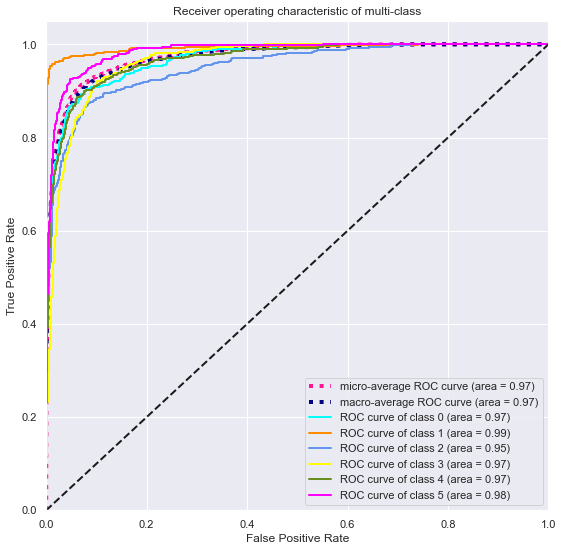

In [56]:
# 11. THE ROC CURVES
# 11.0 On validation set
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

y_test_onehot = pd.get_dummies(tuned2_label_pred_val)

lw = 2

oh_enc = OneHotEncoder(sparse = False)
true = true_classes.reshape(len(true_classes), 1)
ohe_true_classes = oh_enc.fit_transform(true)
print(ohe_true_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ohe_true_classes[:, i], tuned2_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(ohe_true_classes.ravel(), tuned2_val_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label = 'micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color = 'deeppink', linestyle = ':', linewidth = 4)

plt.plot(fpr["macro"], tpr["macro"],
         label = 'macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color = 'navy', linestyle =':', linewidth = 4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow', 'olivedrab', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = lw,
             label = 'ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw = lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of multi-class')
plt.legend(loc = "lower right")
plt.show()

#### On test set

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


C:\Users\yye\AppData\Local\Temp\ipykernel_28284\1990589473.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


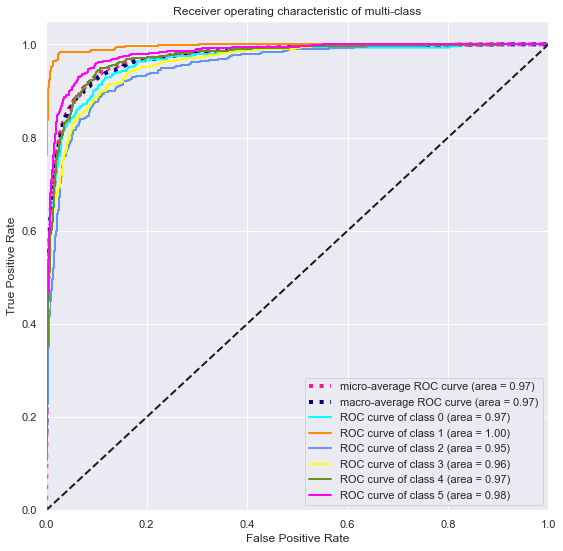

In [ ]:
#11.1 Plotting linewidth:

true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

y_test_onehot = pd.get_dummies(tuned2_label_pred)

lw = 2

oh_enc = OneHotEncoder(sparse = False)
true = true_classes.reshape(len(true_classes), 1)
ohe_true_classes = oh_enc.fit_transform(true)
print(ohe_true_classes)

#11.2 Computing ROC & ROC for each class:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ohe_true_classes[:, i], tuned_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#11.3 Computing micro-average ROC & AUC:
fpr["micro"], tpr["micro"], _ = roc_curve(ohe_true_classes.ravel(), tuned_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#11.4 Computing macro-average ROC & AUC:
#11.4.1 Aggregate all false positive rates:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#11.4.2 Interpolate all ROC curves at these points:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#11.4.3 Finally, average it and compute AUC:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#11.5 Plotting all ROC curves:
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label = 'macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color = 'navy', linestyle =':', linewidth = 4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow', 'olivedrab', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = lw,
             label = 'ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw = lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of multi-class')
plt.legend(loc = "lower right")
plt.show()

# Transfer Learning

## Create a model based on VGG16

In [57]:
# 12. TRANSFER LEARNING
# 12.1 Define a function that create the model architecutre based on VGG16
def create_model():
    # 12.1.1 Import VGG16 and freeze the parameters
    base = VGG16(include_top=False, weights="imagenet", input_shape=(64,64,3), classes=6)
    base.trainable=False # freezing the model to save computation time
    
    # 12.1.2 Create a sequential model and add the convolutional layers of VGG16
    tl_model = Sequential()
    tl_model.add(base)

    # 12.1.3 Flatten the model, because dense layers expect vectors:
    tl_model.add(layers.Flatten())
    # 12.1.4 Adding two dense layers, L1 & L2 regularizer with default value of l1 = 0.01 and l2 = 0.01, and a dropout layer:
    tl_model.add(layers.Dense(256,
                                activation = 'relu', kernel_regularizer = regularizers.L1L2()))
    tl_model.add(layers.Dropout(0.5))
    # 12.1.5 Add the output layer
    tl_model.add(layers.Dense(6, activation = 'softmax'))
    # 12.1.6 Compile the model
    tl_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return tl_model
tl_model = create_model()
tl_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_15 (Dense)            (None, 256)               524544    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 15,240,774
Trainable params: 526,086
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# 12.2 Define a function that define the parameteres of callbacks
# Note that the weights of best model during the training will be saved in the format ".ckpt"
# This setting can help avoid overfitting
def create_callbacks():
  early_stopping = EarlyStopping(patience=5, monitor='val_loss', verbose=1)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=0.001,
                                patience=5, mode='min',
                                verbose=1)

  model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                     filepath='tl_best_model',
                                     save_weights_only=True,
                                     save_best_only=True,
                                     verbose=1)
  callbacks = [
      early_stopping,
      reduce_lr,
      model_checkpoint
  ]

  return callbacks

In [ ]:
#13. TRAINING & ASSESSING THE TRANSFER LEARNING CNN MODEL

#13.1 Training the CNN model - Note: learning rate in the Adam optimizir = 0.001:
tuned_history = tuned_model.fit(train_data,
                             epochs = 40,
                             batch_size = 64,
                             validation_data = val_data,
                             callbacks =create_callbacks())

Epoch 1/40
176/176 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.7252
Epoch 1: val_loss improved from inf to 0.54112, saving model to best-model.h5
176/176 [==============================] - 190s 1s/step - loss: 0.7291 - accuracy: 0.7252 - val_loss: 0.5411 - val_accuracy: 0.8028 - lr: 0.0010
Epoch 2/40
176/176 [==============================] - ETA: 0s - loss: 0.5342 - accuracy: 0.8087
Epoch 2: val_loss improved from 0.54112 to 0.51427, saving model to best-model.h5
176/176 [==============================] - 287s 2s/step - loss: 0.5342 - accuracy: 0.8087 - val_loss: 0.5143 - val_accuracy: 0.8056 - lr: 0.0010
Epoch 3/40
176/176 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.8272
Epoch 3: val_loss improved from 0.51427 to 0.49951, saving model to best-model.h5
176/176 [==============================] - 195s 1s/step - loss: 0.4826 - accuracy: 0.8272 - val_loss: 0.4995 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 4/40
176/176 [===============

In [ ]:
tl_history_df = pd.DataFrame(tuned_history.history)
tl_history_df.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.729141,0.725200,0.541122,0.802782,0.001
1,0.534223,0.808727,0.514272,0.805635,0.001
2,0.482634,0.827248,0.499509,0.819543,0.001
3,0.444855,0.834639,0.478103,0.836305,0.001
4,0.424097,0.842030,0.497986,0.817760,0.001


Text(0.5, 1.0, 'Model accuracy')

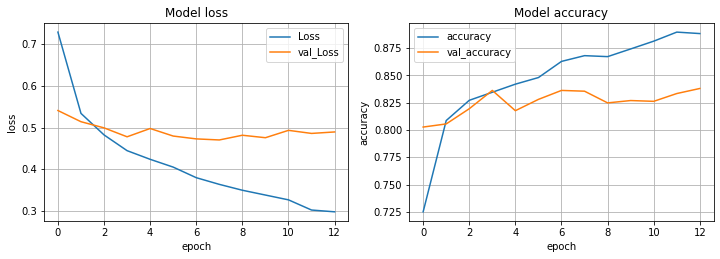

In [ ]:
#13.2 Plotting the training and validation performance:
plt.figure(figsize = (12, 8))

plt.subplot(2, 2, 1)
plt.plot(tuned_history.history['loss'], label = 'Loss')
plt.plot(tuned_history.history['val_loss'], label = 'val_Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.title('Model loss')

plt.subplot(2, 2, 2)
plt.plot(tuned_history.history['accuracy'], label = 'accuracy')
plt.plot(tuned_history.history['val_accuracy'], label = 'val_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.title('Model accuracy')

In [59]:
# 13.3 Load the saved weights from the best model, and evaluate the accuracy on test set
tl_model = create_model()
tl_model.load_weights('./tl_best_model.ckpt')
tl_val_loss, tl_val_accuracy = tl_model.evaluate(val_data)
tl_test_loss, tl_test_accuracy = tl_model.evaluate(test_data)

47/47 [==============================] - 36s 761ms/step - loss: 0.4560 - accuracy: 0.8353


In [60]:
print(f"Val accuracy: {tl_val_accuracy}, val loss: {tl_val_loss}, Test accuracy: {tl_test_accuracy}, test loss: {tl_test_loss}") 

Val accuracy: 0.8355920314788818, val loss: 0.47050774097442627, Test accuracy: 0.8353333473205566, test loss: 0.45597925782203674


In [61]:
tl_val_pred = tl_model.predict(val_data)
tl_label_pred_val = np.argmax(tl_val_pred, axis = 1) 
tl_test_pred = tl_model.predict(test_data)
tl_label_pred = np.argmax(tl_test_pred, axis = 1) 
print(tl_label_pred)

47/47 [==============================] - 35s 751ms/step
[0 5 0 ... 3 5 5]


## Confusion Matrix

#### CM on validation set

           buildings  forest  glacier  mountain  sea  street
buildings        360       3        3         4    6      62
forest             2     424        3         8    6      11
glacier            1       4      342        81   46       6
mountain           2       1       51       407   36       5
sea                8       2       23        38  377       6
street            24       6        6         3    4     433


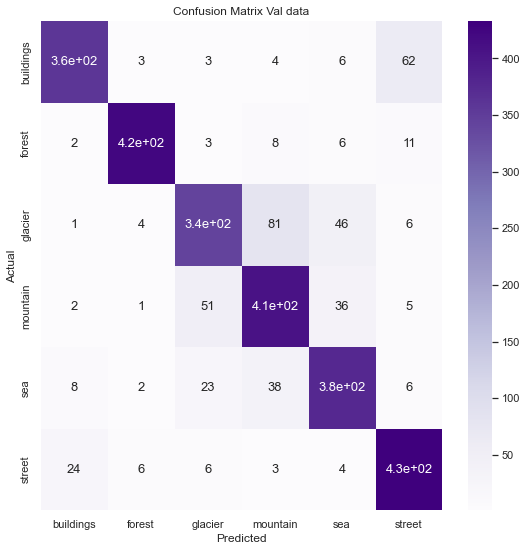

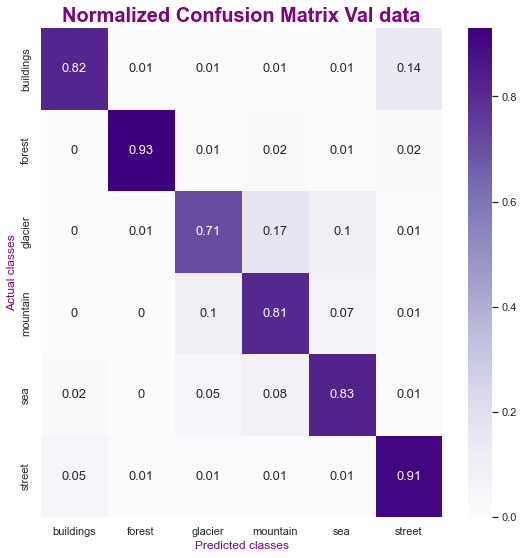

In [62]:
# 13.4 Confusion matrix calculation and plot
# 13.4.1 Confusion matrix on validation set
true_classes = val_data.classes
conf_mat_val = confusion_matrix(y_true = true_classes, y_pred = tl_label_pred_val)

conf_mat_val = pd.DataFrame(conf_mat_val, index = test_data.class_indices.keys(), columns = test_data.class_indices.keys())
print(conf_mat_val)
cm = confusion_matrix(true_classes, tl_label_pred_val)
ax = plt.axes()
sns.heatmap(cm, cmap = "Purples", annot = True, 
           annot_kws = {"size": 13}, 
           xticklabels = val_data.class_indices,
           yticklabels = val_data.class_indices, ax = ax)
ax.set_title('Confusion Matrix Val data')
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.set(rc = {'figure.figsize':(9, 9)})
plt.show()
# plt.savefig("CM_heatmap.pdf", format = "pdf")

cm_normalized = np.round(cm/np.sum(cm, axis = 1).reshape(-1, 1), 2)

cm = confusion_matrix(true_classes, tl_label_pred_val)
ax = plt.axes()
sns.heatmap(cm_normalized, cmap = "Purples", annot = True, 
           annot_kws = {"size": 13}, 
           xticklabels = val_data.class_indices,
           yticklabels = val_data.class_indices, ax = ax)
plt.xlabel("Predicted classes", color = "Purple")
plt.ylabel("Actual classes", color = "Purple")
plt.title("Normalized Confusion Matrix Val data", fontsize = 20, color = "Purple", fontweight = 'bold')
plt.show()
# plt.savefig("norm_CM_heatmap.pdf", format = "pdf")

#### CM on test set

In [ ]:
# 13.4 Confusion Matrix
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())
from sklearn.metrics import confusion_matrix
tl_conf_mat = confusion_matrix(y_true = true_classes, y_pred = tl_label_pred)
tl_conf_mat = pd.DataFrame(tl_conf_mat, index = test_data.class_indices.keys(), columns = test_data.class_indices.keys())

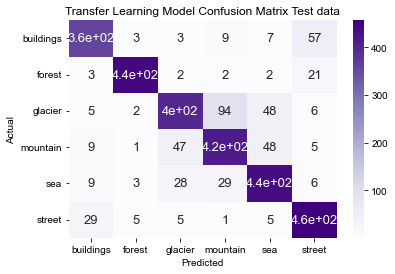

In [ ]:
tl_cm = confusion_matrix(true_classes, tl_label_pred)
ax = plt.axes()
sns.heatmap(tl_cm, cmap = "Purples", annot = True, 
           annot_kws = {"size": 13}, 
           xticklabels = test_data.class_indices,
           yticklabels = test_data.class_indices, ax = ax)
ax.set_title('Transfer Learning Model Confusion Matrix Test data')
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.set(rc = {'figure.figsize':(9, 9)})
plt.show()
# plt.savefig("tl_CM_heatmap", format = "pdf")

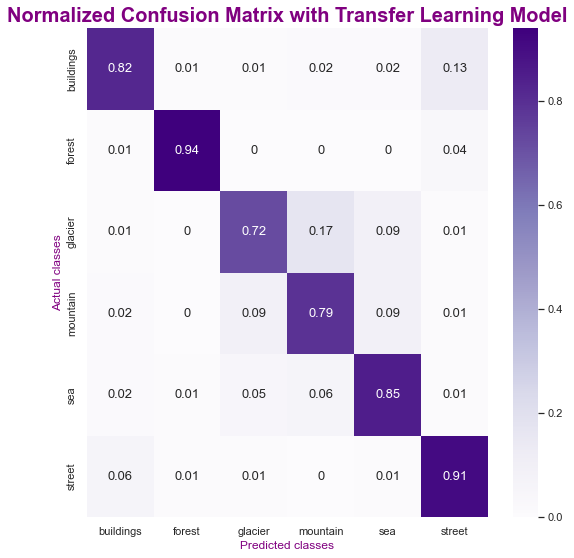

In [ ]:
tl_cm_normalized = np.round(tl_cm/np.sum(tl_cm, axis = 1).reshape(-1, 1), 2)

cm = confusion_matrix(true_classes, tl_label_pred)
ax = plt.axes()
sns.heatmap(tl_cm_normalized, cmap = "Purples", annot = True, 
           annot_kws = {"size": 13}, 
           xticklabels = test_data.class_indices,
           yticklabels = test_data.class_indices, ax = ax)
plt.xlabel("Predicted classes", color = "Purple")
plt.ylabel("Actual classes", color = "Purple")
plt.title("Normalized Confusion Matrix with Transfer Learning Model", fontsize = 20, color = "Purple", fontweight = 'bold')
plt.show()
# plt.savefig("tl_norm_CM_heatmap", format = "pdf")

In [ ]:
tl_conf_mat
# tuned_conf_mat.to_csv("/content/drive/MyDrive/Colab Notebooks/Deep learning assignment/tuned_confusion_matrix.csv")

,buildings,forest,glacier,mountain,sea,street
buildings,358,3,3,9,7,57
forest,3,444,2,2,2,21
glacier,5,2,398,94,48,6
mountain,9,1,47,415,48,5
sea,9,3,28,29,435,6
street,29,5,5,1,5,456


## Metrics
### Metrics on validation set

In [63]:
# 13.5.0 Metrics on validation set:

# Precision, recall & f1-score:
# Measure on the validation set

true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

report = classification_report(true_classes, tl_label_pred_val, target_names = class_labels)
print(report)

# Accuracy:
accuracy = accuracy_score(y_true = true_classes, y_pred = tl_label_pred_val)
print("Accuracy score = ", accuracy)

# Sensitivity - simply averaging all the sensitivities by class:
sensitivity = recall_score(y_true = true_classes, y_pred = tl_label_pred_val, average = "macro")
print("Sensitivity score = ", sensitivity)

# F1-score:
f1score = f1_score(y_true = true_classes, y_pred = tl_label_pred_val, average = 'weighted')
print("F1-score = ", f1score)

# Specificity:
def specificity(y_true: np.array, y_pred: np.array, classes: set = None):

    if classes is None: # Determine classes from the values
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))

    specs = []
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)

        specificity_val = tn / (tn + fp)
        specs.append(specificity_val)

    return np.mean(specs)
specificity = specificity(y_true = true_classes, y_pred = tl_label_pred_val)
print("Specificity score = ", specificity)

res = []
for l in [0, 1, 2, 3, 4, 5]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(true_classes) == l,
                                                      np.array(val_label_pred) == l,
                                                      pos_label = True,average = None)
    res.append([l,recall[0],recall[1]])

print(pd.DataFrame(res,columns = ['class', 'specificity', 'sensitivity']))

              precision    recall  f1-score   support

   buildings       0.91      0.82      0.86       438
      forest       0.96      0.93      0.95       454
     glacier       0.80      0.71      0.75       480
    mountain       0.75      0.81      0.78       502
         sea       0.79      0.83      0.81       454
      street       0.83      0.91      0.87       476

    accuracy                           0.84      2804
   macro avg       0.84      0.84      0.84      2804
weighted avg       0.84      0.84      0.84      2804

Accuracy score =  0.8355920114122682
Sensitivity score =  0.8365259710822818
F1-score =  0.8355172369892353
Specificity score =  0.9669959907459642
   class  specificity  sensitivity
0      0     0.946746     0.776256
1      1     0.988936     0.905286
2      2     0.960843     0.697917
3      3     0.916160     0.828685
4      4     0.984681     0.671806
5      5     0.951031     0.863445


### Metrics on test set

In [ ]:
# 13.5 Precision, recall & f1-score:
from sklearn.metrics import classification_report,plot_confusion_matrix
tl_report = classification_report(true_classes, tl_label_pred, target_names = class_labels)
print(tl_report)
# 13.6 Accuracy:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true = true_classes, y_pred = tl_label_pred)
print("Accuracy score = ", accuracy)

# 13.7 Sensitivity - simply averaging all the sensitivities by class:
from sklearn.metrics import recall_score
sensitivity = recall_score(y_true = true_classes, y_pred = tl_label_pred, average = "macro")
print("Sensitivity score = ", sensitivity)

# 13.8 F1-score:
from sklearn.metrics import f1_score
f1score = f1_score(y_true = true_classes, y_pred = tl_label_pred, average = 'weighted')
print("F1-score = ", f1score)
# 13.9 Specificity:
def specificity(y_true: np.array, y_pred: np.array, classes: set = None):

    if classes is None: # Determine classes from the values
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))

    specs = []
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)

        specificity_val = tn / (tn + fp)
        specs.append(specificity_val)

    return np.mean(specs)
specificity = specificity(y_true = true_classes, y_pred = tl_label_pred)
print("Specificity score = ", specificity)

# 13.10 Specificity & sensitivity per class:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in [0,1,2,3,4,5]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(true_classes) == l,
                                                      np.array(tl_label_pred) == l,
                                                      pos_label = True,average = None)
    res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

              precision    recall  f1-score   support

   buildings       0.87      0.82      0.84       437
      forest       0.97      0.94      0.95       474
     glacier       0.82      0.72      0.77       553
    mountain       0.75      0.79      0.77       525
         sea       0.80      0.85      0.82       510
      street       0.83      0.91      0.87       501

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.83      3000

Accuracy score =  0.8353333333333334
Sensitivity score =  0.8382064175776632
F1-score =  0.8349556661895813
Specificity score =  0.9669207722804023


,class,specificity,sensitivity
0,0,0.978541,0.819222
1,1,0.994458,0.936709
2,2,0.965264,0.719711
3,3,0.945455,0.790476
4,4,0.955823,0.852941
5,5,0.961985,0.910180


## AUC-ROC CURVIES
### AUC-ROC CURVIES ON VALIDATION SET

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


C:\Users\yye\AppData\Local\Temp\ipykernel_28620\3202517229.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


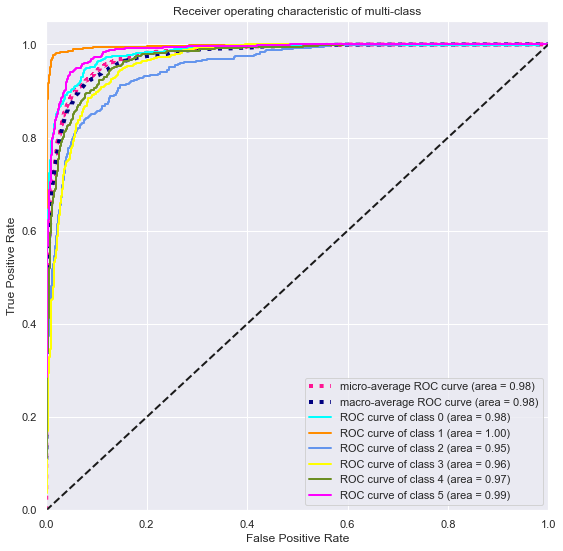

In [64]:
# 14 AUC-ROC CURVES
# 14.0 On validation set

# 11. THE ROC CURVES
# 11.0 On validation set
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

y_test_onehot = pd.get_dummies(tl_label_pred_val)

lw = 2

oh_enc = OneHotEncoder(sparse = False)
true = true_classes.reshape(len(true_classes), 1)
ohe_true_classes = oh_enc.fit_transform(true)
print(ohe_true_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ohe_true_classes[:, i], tl_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(ohe_true_classes.ravel(), tl_val_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label = 'micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color = 'deeppink', linestyle = ':', linewidth = 4)

plt.plot(fpr["macro"], tpr["macro"],
         label = 'macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color = 'navy', linestyle =':', linewidth = 4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow', 'olivedrab', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = lw,
             label = 'ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw = lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of multi-class')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
# 14.1  On testing set
# 14.1.0 Preparing for ROC curve:
y_test_onehot = pd.get_dummies(tl_label_pred)
y_test_onehot.tail()

,0,1,2,3,4,5
2995,0,0,0,0,0,1
2996,0,0,0,0,0,1
2997,0,0,0,1,0,0
2998,0,0,0,0,0,1
2999,0,0,0,0,0,1


[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


C:\Users\yye\AppData\Local\Temp\ipykernel_29076\3547252839.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


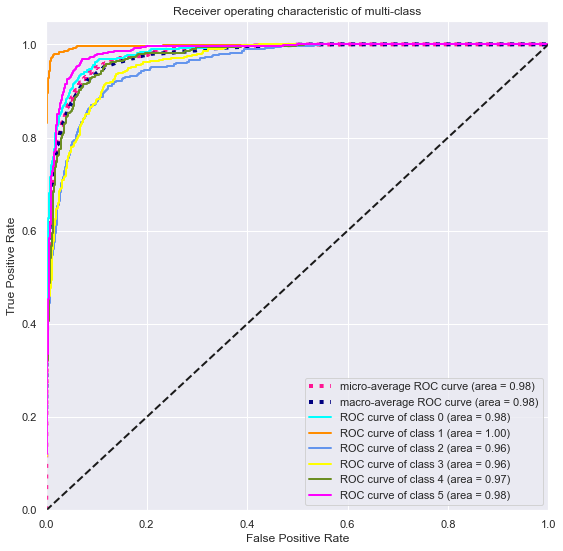

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# 14.1.1 Plotting linewidth:

true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

lw = 2

oh_enc = OneHotEncoder(sparse = False)
true = true_classes.reshape(len(true_classes), 1)
ohe_true_classes = oh_enc.fit_transform(true)
print(ohe_true_classes)

# 14.1.2 Computing ROC & ROC for each class:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ohe_true_classes[:, i], tl_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 14.1.3 Computing micro-average ROC & AUC:
fpr["micro"], tpr["micro"], _ = roc_curve(ohe_true_classes.ravel(), tl_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 14.1.4 Computing macro-average ROC & AUC:
#10.4.1 Aggregate all false positive rates:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# 14.1.4.2 Interpolate all ROC curves at these points:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# 14.1.4.3 Finally, average it and compute AUC:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 14.1.5 Plotting all ROC curves:
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label = 'macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color = 'navy', linestyle =':', linewidth = 4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow', 'olivedrab', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = lw,
             label = 'ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw = lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of multi-class')
plt.legend(loc = "lower right")
plt.show()